# Evaluation merch_division_nm

Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold, cross_validate, cross_val_score, train_test_split

from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, plot_confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sn

import os

%matplotlib inline

Reading Data

In [2]:
df_product_detailed = pd.read_csv('clean_data/cleaned_products_detailed.csv')
df_product_standard = pd.read_csv('clean_data/cleaned_products.csv')

df_product_standard = df_product_standard[["ctr_product_num", "merch_division_nm"]]

Set Random State

In [3]:
np.random.seed(42) 

Scoring Functions

In [4]:
def score_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    predictions_train = model.predict(X_train)
    predictions_test = model.predict(X_test)

    return [predictions_train, predictions_test]

def get_metrics(y_train, y_test, predictions_train, predictions_test):
    
    metrics_dict = {
        "Train Accuracy Score": accuracy_score(y_train, predictions_train),
        "Test Accuracy Score": accuracy_score(y_test, predictions_test),
        "Train F1 Macro Score": f1_score(y_train, predictions_train, average="macro"),
        "Test F1 Macro Score": f1_score(y_test, predictions_test, average="macro"),
        "Train Precision Macro Score": precision_score(y_train, predictions_train, average="macro"),
        "Test Precision Macro Score": precision_score(y_test, predictions_test, average="macro"),
        "Train Recall Macro Score": recall_score(y_train, predictions_train, average="macro"),
        "Test Recall Macro Score": recall_score(y_test, predictions_test, average="macro"),
    }

    return metrics_dict

def score_cv(model, X, y, k = 5):
    k_folds = KFold(n_splits = k)
    #acc = None
    #acc = cross_val_score(model, X, y, cv=k_folds, n_jobs= -1)
    #f1_macro = cross_val_score(model, X, y, scoring="f1_macro", cv=k_folds, n_jobs= -1)

    scoring = ["precision_macro", "recall_macro", "f1_macro", "accuracy"]

    scores = cross_validate(model, X, y, cv=k_folds, n_jobs= -1, return_train_score=True, error_score="raise", scoring=scoring)

    return scores, None

def print_results(results):
    for result in results:
        print(result[0])
        for i in result[2][0]:
            print(i, [round(x, 2) for x in result[2][0][i]])

Models and Embeddings

In [5]:
evaluation_models = [
    ("MLP_3", MLPClassifier(hidden_layer_sizes=(150, 100, 50), random_state=1, max_iter=300)),
]

all_files = os.listdir("embeddings")    
embeddings = list(filter(lambda f: f.endswith('.csv'), all_files))


In [6]:
results = []
for i, filename in enumerate(embeddings):
    test_embedding = pd.read_csv("embeddings/" + filename, index_col=0, header=0)
    test_embedding = test_embedding.sample(frac=1)[:100000]
    df_combined = test_embedding.join(df_product_standard.set_index("ctr_product_num"))
    df_combined.dropna(inplace=True)

    drop_for_X = ["merch_division_nm"]

    X = df_combined.drop(columns=drop_for_X)
    Y = df_combined[["merch_division_nm"]]

    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

    for model in evaluation_models:
        results.append([filename] + score_model(model[1], X_train, X_test, y_train, y_test) + [X_train, X_test, y_train, y_test])

c:\Users\Stephen\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1118: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Stephen\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1118: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Stephen\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Stephen\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\

Generate Figures

c:\Users\Stephen\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


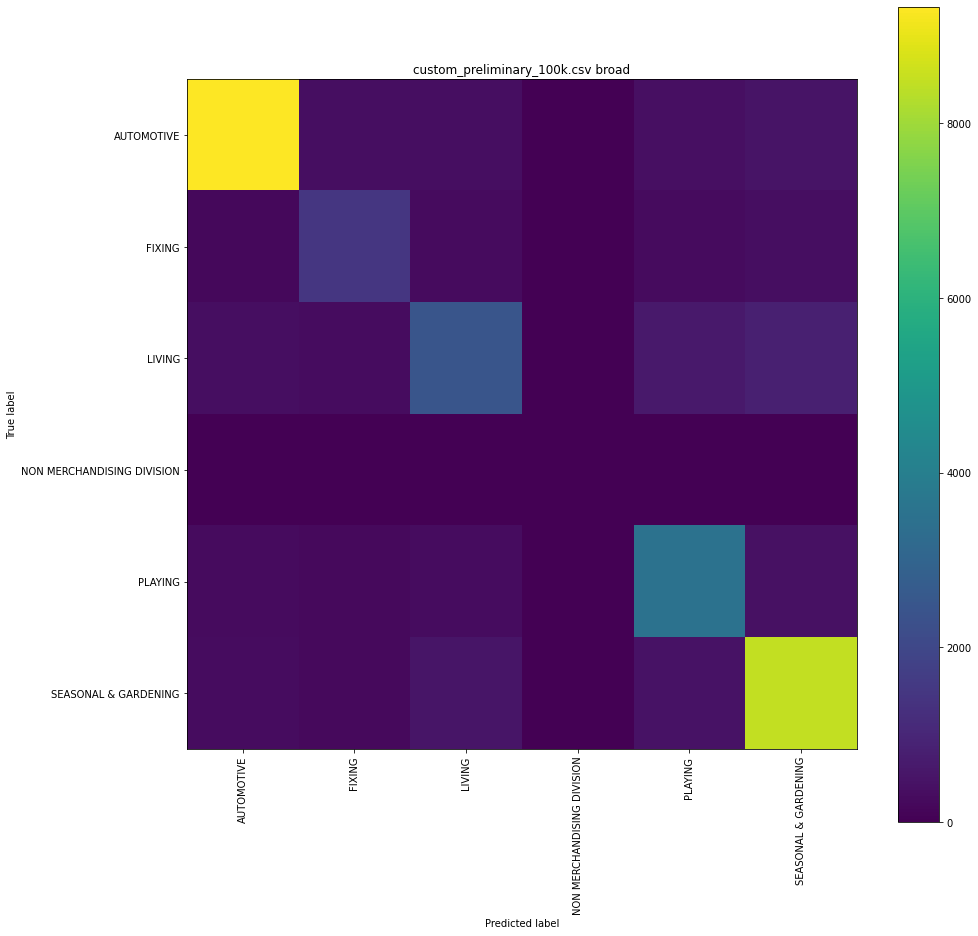

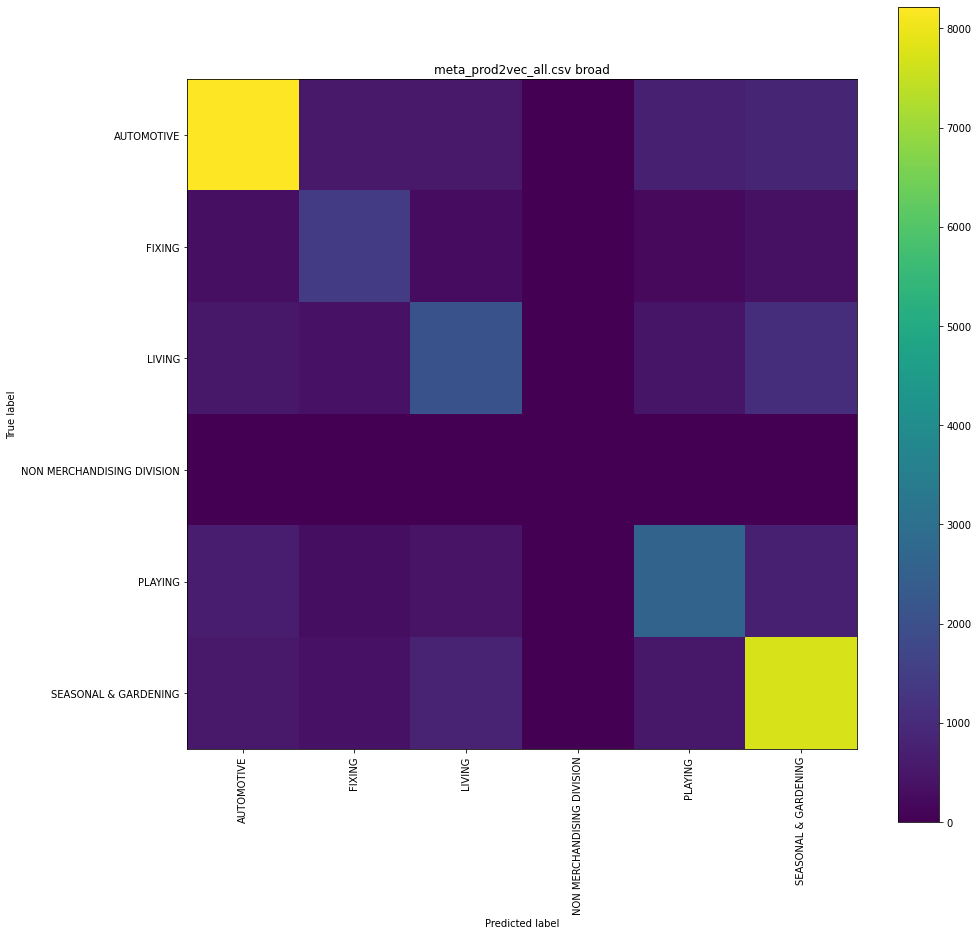

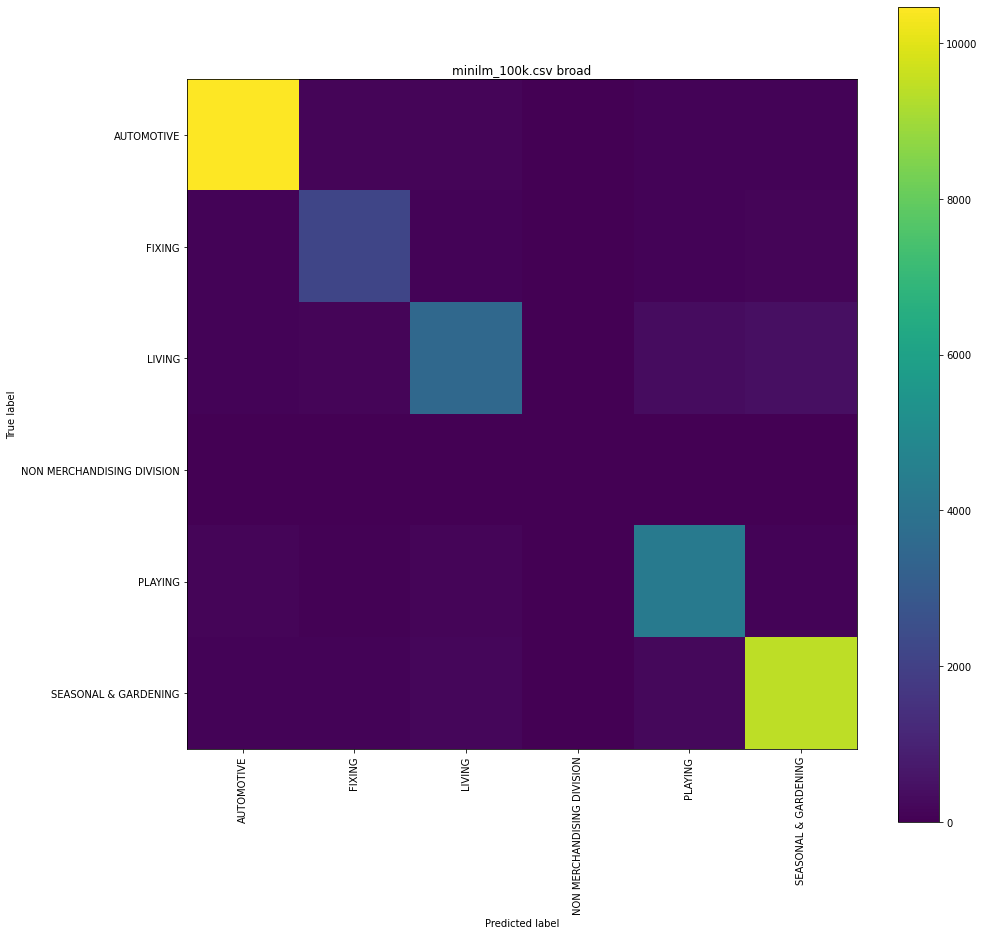

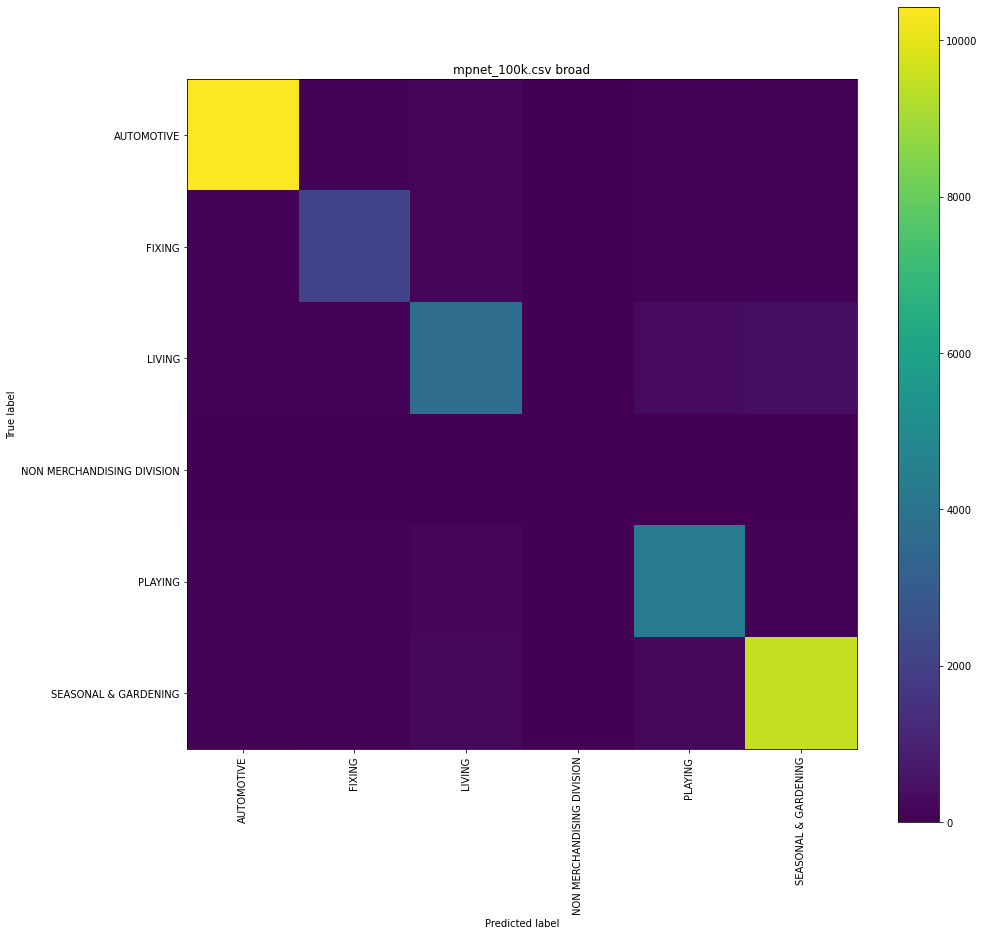

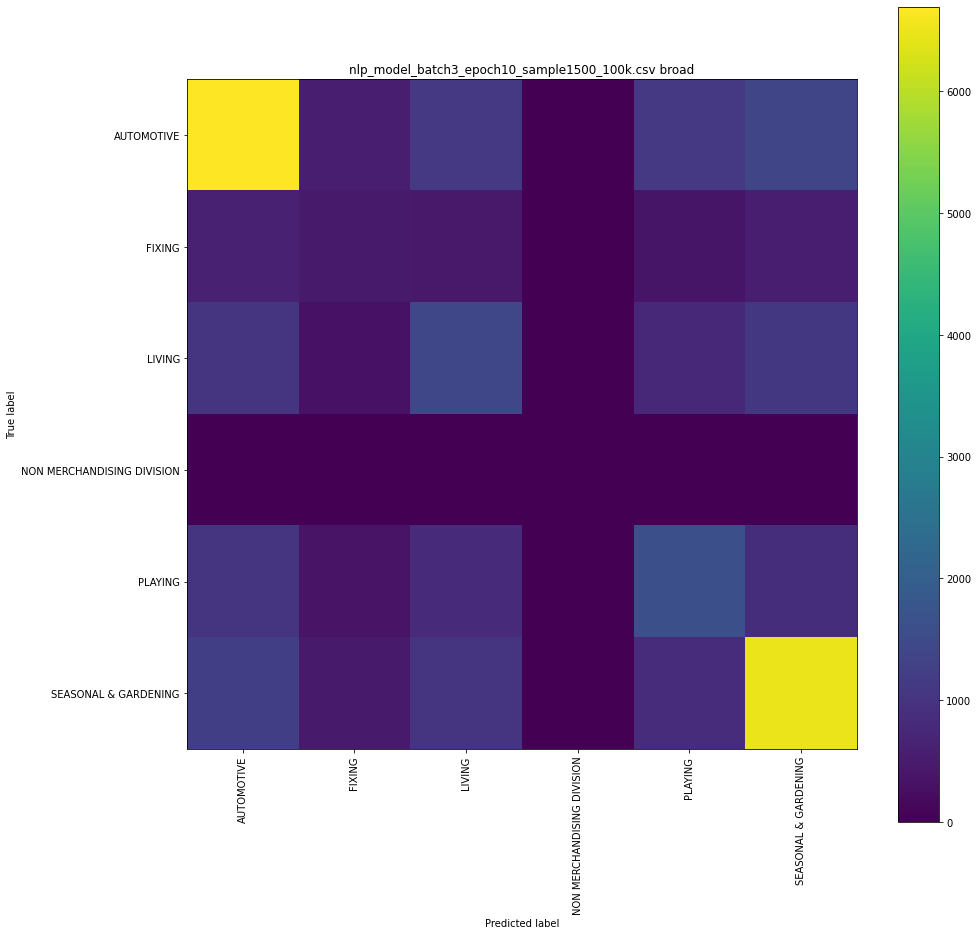

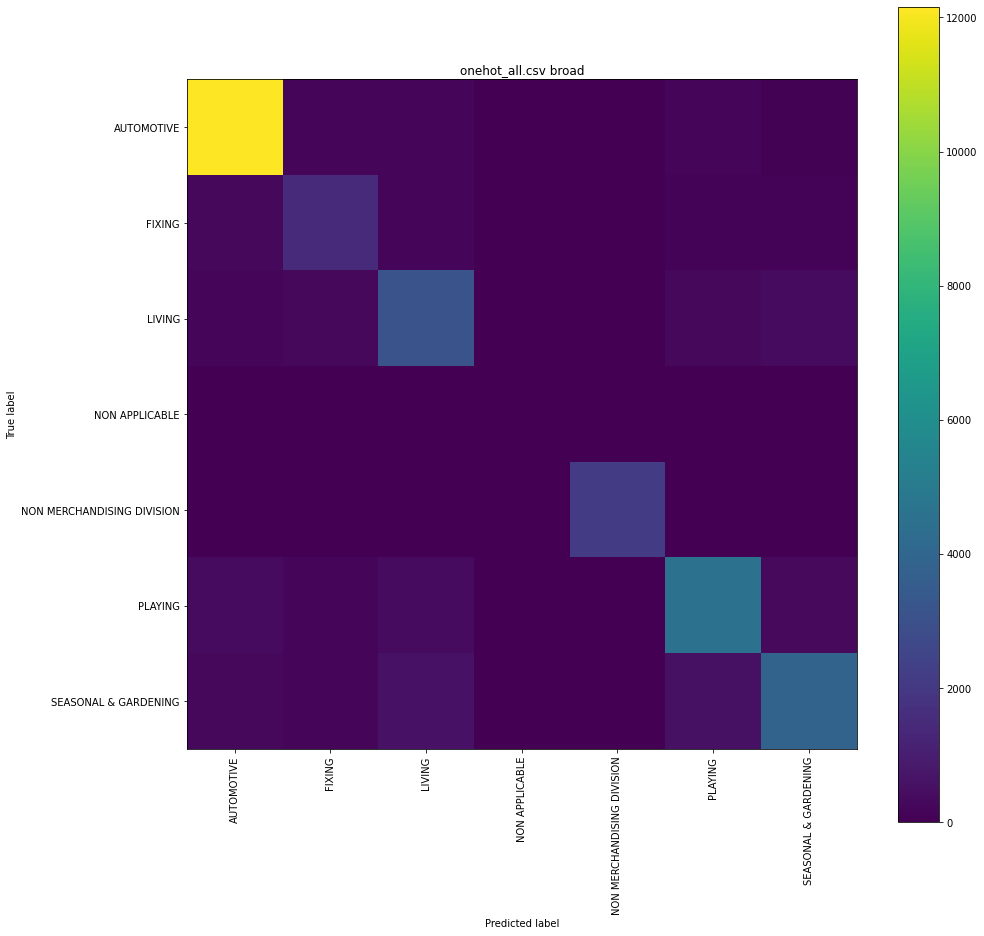

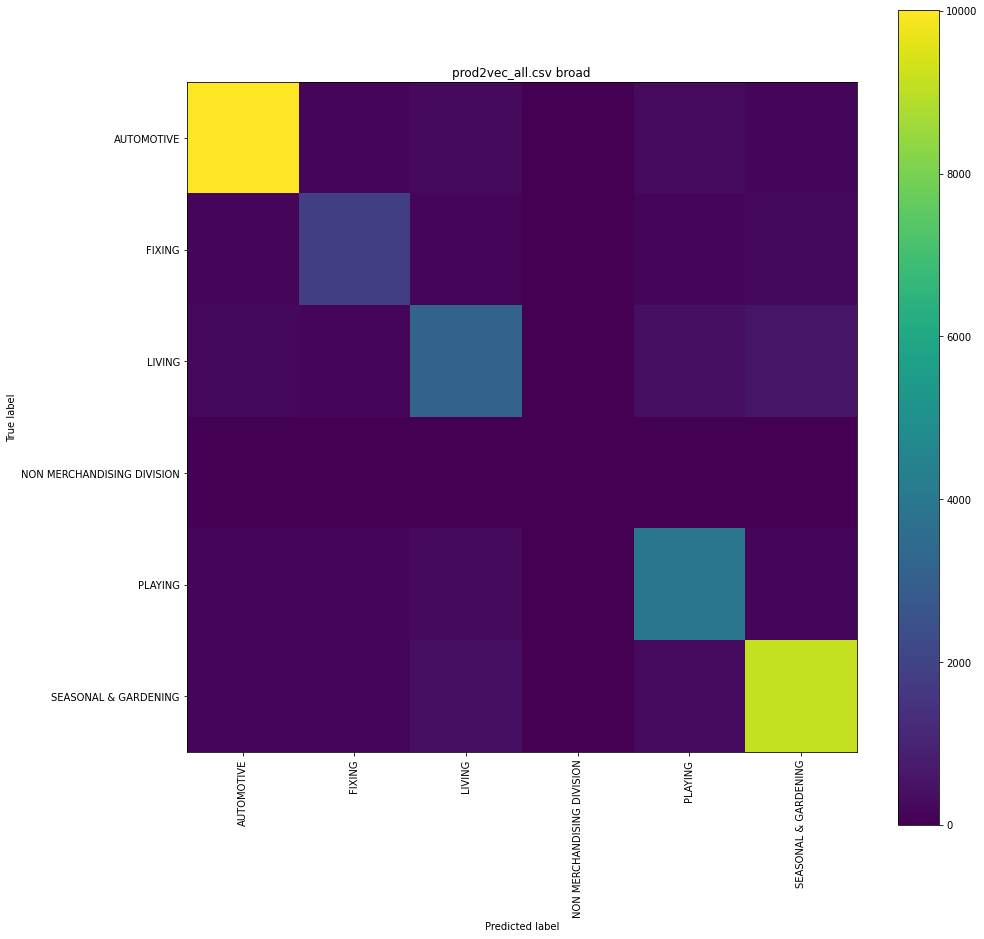

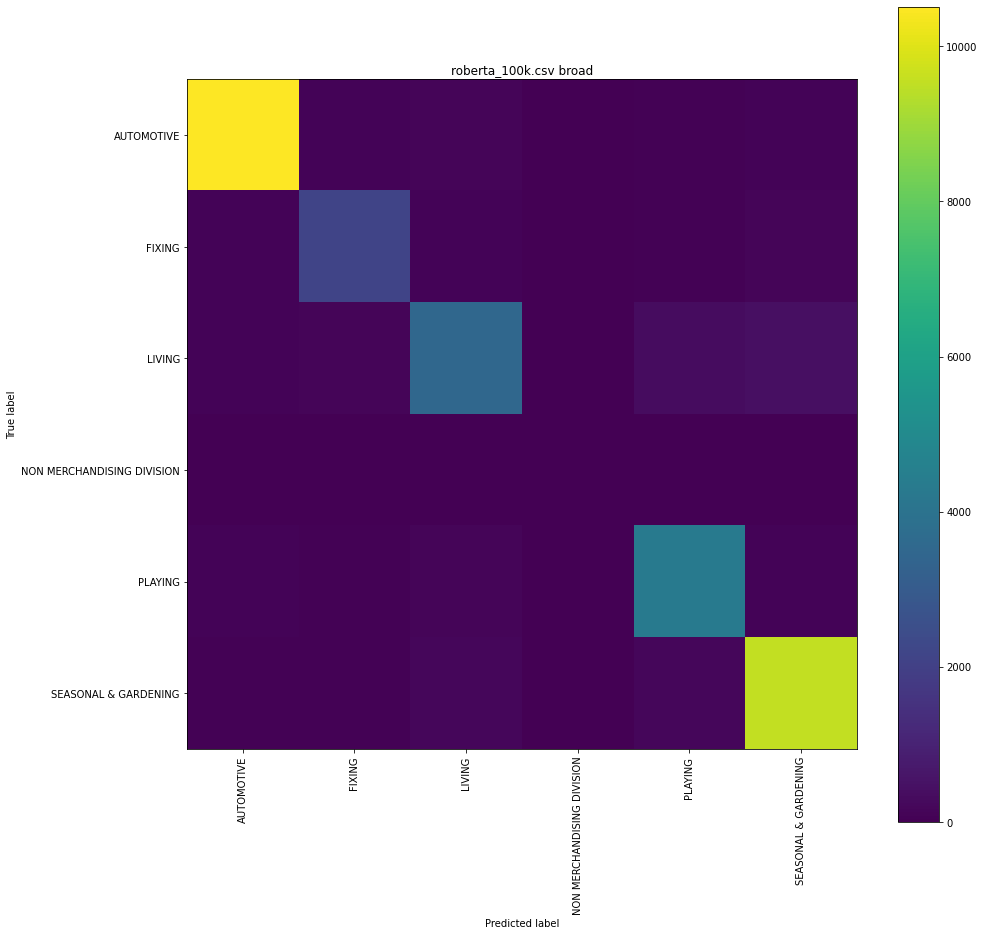

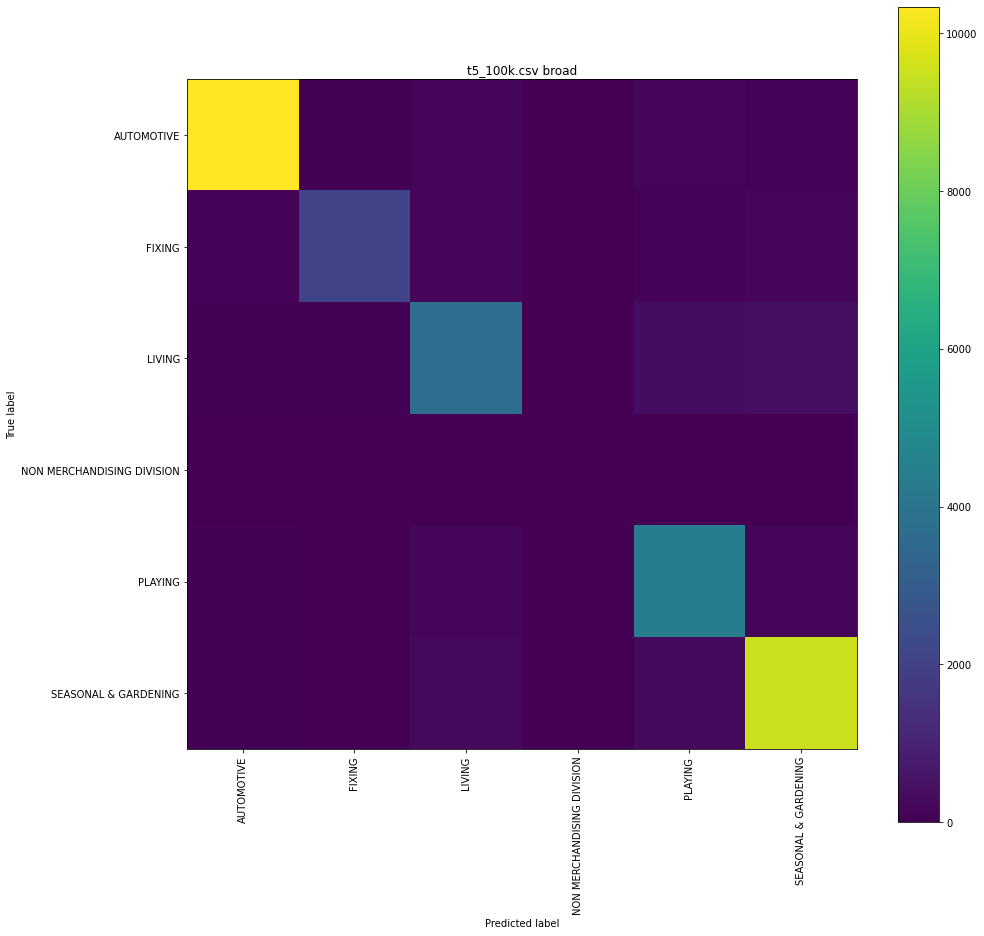

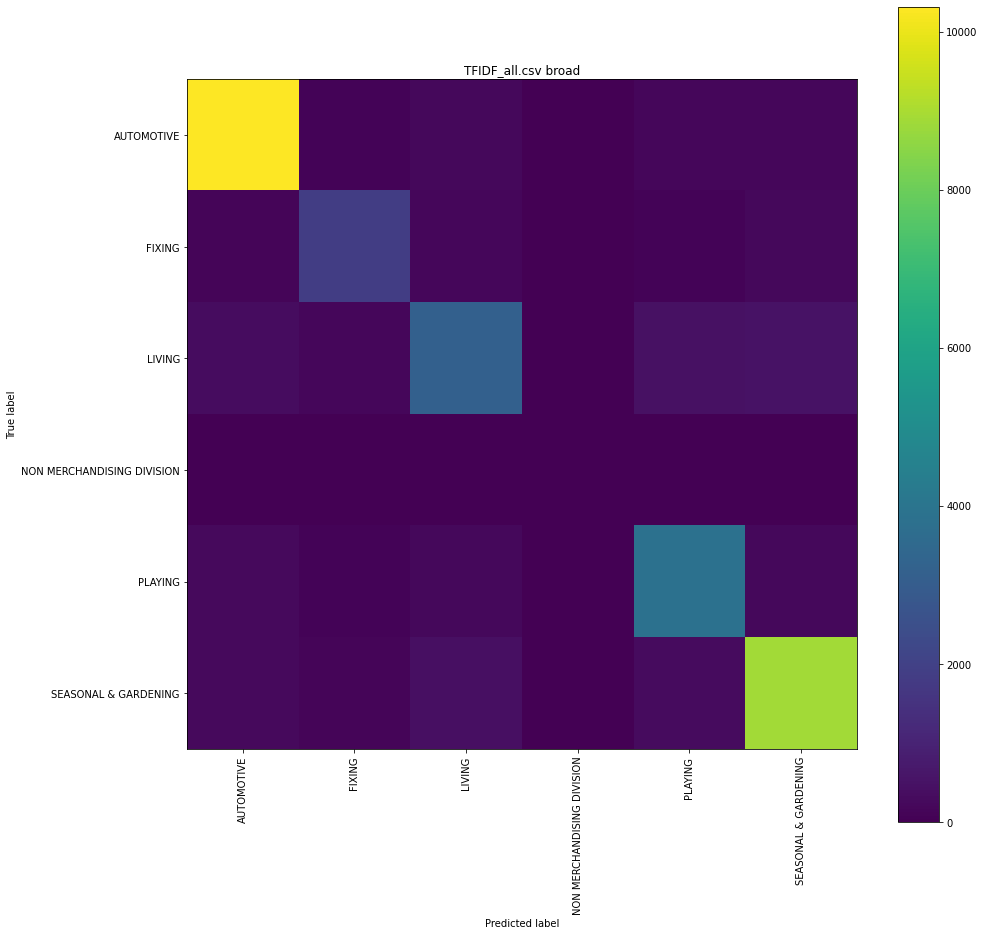

In [7]:
result_metrics = {}
for result in results:
    cm = confusion_matrix(result[6], result[2])
    cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = np.unique(result[6]))
    fig, ax = plt.subplots(figsize=(15, 15))
    cm_display.plot(xticks_rotation ="vertical", include_values=False, ax=ax)
    plt.title(result[0] + " broad")
    plt.savefig("results/"+result[0].split(".")[0]+"_broad.png", facecolor="white", bbox_inches='tight')
    result_metrics[result[0]] = get_metrics(result[5], result[6], result[1], result[2])



In [8]:
results_df = pd.DataFrame.from_dict(result_metrics, orient="index")

In [9]:
results_df.to_csv("results/metrics_broad.csv")